In [1]:
cd ../

/home/ubuntu/github/predictive-maintenance/ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from sklearn.preprocessing import normalize

from tqdm import tqdm

%matplotlib inline

tqdm.monitor_interval = 0

In [3]:
data_dir = 'data/dataset/'
model_save_path = 'data/wtte/model/saved_model.h5'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
print(telemetry.machineID.nunique())
print(failures.machineID.nunique())

100
98


## Prepare Data

In [10]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [13]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [14]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [15]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

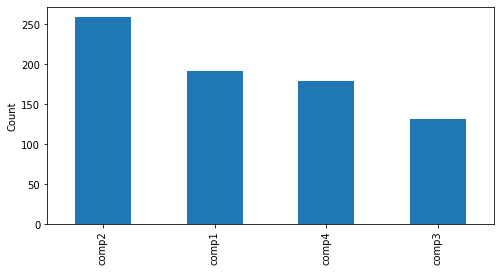

In [16]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Normliaze

In [17]:
telemetry.iloc[:, 2:] = normalize(telemetry.iloc[:, 2:], axis=0)

## Change the Life-cycle

In [18]:
# calculate the mean, std, max, and min values for 24h periods
def timesteps_handler(df, period='24H', fields = ['volt', 'rotate', 'pressure', 'vibration']):
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').mean().unstack())
    df_mean_xh = pd.concat(temp, axis=1)
    df_mean_xh.columns = [i + '_mean_{}'.format(period.lower()) for i in fields]
    df_mean_xh.reset_index(inplace=True)

    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').std().unstack())
    df_sd_xh = pd.concat(temp, axis=1)
    df_sd_xh.columns = [i + '_sd_{}'.format(period.lower()) for i in fields]
    df_sd_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').max().unstack())
    df_max_xh = pd.concat(temp, axis=1)
    df_max_xh.columns = [i + '_max_{}'.format(period.lower()) for i in fields]
    df_max_xh.reset_index(inplace=True)
    
    temp = []
    for col in fields:
        temp.append(pd.pivot_table(df,
                                   index='datetime',
                                   columns='machineID',
                                   values=col).resample(period, closed='left', label='right').min().unstack())
    df_min_xh = pd.concat(temp, axis=1)
    df_min_xh.columns = [i + '_min_{}'.format(period.lower()) for i in fields]
    df_min_xh.reset_index(inplace=True)
    
    df = pd.concat([
        df_mean_xh,
        df_sd_xh.iloc[:, 2:6],
        df_max_xh.iloc[:, 2:6],
        df_min_xh.iloc[:, 2:6]], axis=1).dropna()
    return df

In [19]:
# 24h periods
telemetry = timesteps_handler(telemetry)
telemetry.head(10)

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,0.001044,0.001047,0.001037,0.001050,0.000058,0.000118,0.000111,0.000151,0.001139,0.001253,0.001191,0.001338,0.000943,0.000822,0.000792,0.000682
1,1,2015-01-03,0.001058,0.001062,0.001037,0.001030,0.000098,0.000092,0.000123,0.000146,0.001251,0.001234,0.001337,0.001373,0.000877,0.000914,0.000831,0.000774
2,1,2015-01-04,0.001071,0.001091,0.001032,0.001261,0.000070,0.000113,0.000094,0.000215,0.001215,0.001352,0.001222,0.001751,0.000961,0.000889,0.000898,0.000848
3,1,2015-01-05,0.001089,0.001066,0.001068,0.001369,0.000120,0.000081,0.000114,0.000133,0.001344,0.001229,0.001252,0.001638,0.000804,0.000868,0.000868,0.001093
4,1,2015-01-06,0.001065,0.001081,0.001078,0.001136,0.000112,0.000114,0.000112,0.000212,0.001262,0.001367,0.001332,0.001562,0.000792,0.000895,0.000829,0.000869
5,1,2015-01-07,0.001066,0.001080,0.001078,0.001088,0.000110,0.000104,0.000090,0.000113,0.001332,0.001207,0.001254,0.001254,0.000757,0.000821,0.000919,0.000861
6,1,2015-01-08,0.001085,0.001056,0.001018,0.001094,0.000066,0.000094,0.000112,0.000152,0.001197,0.001294,0.001266,0.001440,0.000945,0.000859,0.000844,0.000764
7,1,2015-01-09,0.001072,0.001060,0.001075,0.001030,0.000086,0.000091,0.000101,0.000108,0.001251,0.001256,0.001210,0.001194,0.000894,0.000870,0.000859,0.000761
8,1,2015-01-10,0.001055,0.001109,0.001054,0.001011,0.000091,0.000097,0.000089,0.000121,0.001228,0.001312,0.001234,0.001257,0.000894,0.000954,0.000870,0.000825
9,1,2015-01-11,0.001065,0.001083,0.001050,0.001043,0.000078,0.000078,0.000097,0.000142,0.001204,0.001239,0.001261,0.001302,0.000911,0.000952,0.000848,0.000790


## Train, Validation, Test Split

In [20]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [
        pd.to_datetime("2015-08-01 01:00:00"),
        pd.to_datetime("2015-11-01 01:00:00")
]

telemetry_train = telemetry[telemetry['datetime'] < threshold_dates[0]]
telemetry_valid = telemetry[
    (telemetry['datetime'] >= threshold_dates[0]) &
    (telemetry['datetime'] < threshold_dates[1])
]
telemetry_test = telemetry[(telemetry['datetime'] >= threshold_dates[1])]

failures_train = failures[failures['datetime'] < threshold_dates[0]]
failures_valid = failures[
    (failures['datetime'] >= threshold_dates[0]) &
    (failures['datetime'] < threshold_dates[1])
]
failures_test = failures[(failures['datetime'] >= threshold_dates[1])]

print(len(telemetry_train))
print(len(telemetry_valid))
print(len(telemetry_test))
print(len(failures_train))
print(len(failures_valid))
print(len(failures_test))

21200
9200
6200
458
182
121


In [21]:
telemetry_train.head()

,machineID,datetime,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,1,2015-01-02,0.001044,0.001047,0.001037,0.001050,0.000058,0.000118,0.000111,0.000151,0.001139,0.001253,0.001191,0.001338,0.000943,0.000822,0.000792,0.000682
1,1,2015-01-03,0.001058,0.001062,0.001037,0.001030,0.000098,0.000092,0.000123,0.000146,0.001251,0.001234,0.001337,0.001373,0.000877,0.000914,0.000831,0.000774
2,1,2015-01-04,0.001071,0.001091,0.001032,0.001261,0.000070,0.000113,0.000094,0.000215,0.001215,0.001352,0.001222,0.001751,0.000961,0.000889,0.000898,0.000848
3,1,2015-01-05,0.001089,0.001066,0.001068,0.001369,0.000120,0.000081,0.000114,0.000133,0.001344,0.001229,0.001252,0.001638,0.000804,0.000868,0.000868,0.001093
4,1,2015-01-06,0.001065,0.001081,0.001078,0.001136,0.000112,0.000114,0.000112,0.000212,0.001262,0.001367,0.001332,0.001562,0.000792,0.000895,0.000829,0.000869


In [22]:
failures_train.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
7,2015-03-19 06:00:00,2,comp1


## Prepare the Dataset

In [23]:
def data_handler(df_telemetry, df_failure):
    sample_id = 0
    #cols = ['instance', 'timesteps', 'volt', 'rotate', 'pressure', 'vibration']
    cols = [
        "instance",
        "timesteps",
        "volt_mean_24h",
        "rotate_mean_24h",
        "pressure_mean_24h",
        "vibration_mean_24h",
        "volt_sd_24h",
        "rotate_sd_24h",
        "pressure_sd_24h",
        "vibration_sd_24h",
        "volt_max_24h",
        "rotate_max_24h",
        "pressure_max_24h",
        "vibration_max_24h",
        "volt_min_24h",
        "rotate_min_24h",
        "pressure_min_24h",
        "vibration_min_24h"
    ]
    dataset = pd.DataFrame(columns=cols)
    for machine_id in df_failure.machineID.unique():
        telemetry_sample = df_telemetry[df_telemetry['machineID'] == machine_id].sort_values(by='datetime')
        sample_failure = df_failure[df_failure['machineID'] == machine_id].sort_values(by='datetime')
        
        prev_fail_datetime = pd.to_datetime("1900-01-01 00:00:00")
        for fail_datetime in sample_failure.datetime:
            temp = telemetry_sample[
                (telemetry_sample.datetime > prev_fail_datetime) &
                (telemetry_sample.datetime < fail_datetime)
            ]
            matrix = np.concatenate(
                    (
                        np.array([sample_id] * len(temp))[:, None].astype(np.int16),
                        np.arange(len(temp))[:, None].astype(np.int16),
                        temp[cols[2:]].values
                    ), axis=1
                )
            dataset = dataset.append(pd.DataFrame(matrix, columns=cols), ignore_index=True)  
            prev_fail_datetime = fail_datetime
            sample_id += 1
    dataset['instance'] = dataset['instance'].astype(np.int16)
    dataset['timesteps'] = dataset['timesteps'].astype(np.int16)
    return dataset

In [24]:
train = data_handler(telemetry_train, failures_train)
train.head()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
0,0,0,0.001044,0.001047,0.001037,0.001050,0.000058,0.000118,0.000111,0.000151,0.001139,0.001253,0.001191,0.001338,0.000943,0.000822,0.000792,0.000682
1,0,1,0.001058,0.001062,0.001037,0.001030,0.000098,0.000092,0.000123,0.000146,0.001251,0.001234,0.001337,0.001373,0.000877,0.000914,0.000831,0.000774
2,0,2,0.001071,0.001091,0.001032,0.001261,0.000070,0.000113,0.000094,0.000215,0.001215,0.001352,0.001222,0.001751,0.000961,0.000889,0.000898,0.000848
3,0,3,0.001089,0.001066,0.001068,0.001369,0.000120,0.000081,0.000114,0.000133,0.001344,0.001229,0.001252,0.001638,0.000804,0.000868,0.000868,0.001093
4,1,0,0.001065,0.001081,0.001078,0.001136,0.000112,0.000114,0.000112,0.000212,0.001262,0.001367,0.001332,0.001562,0.000792,0.000895,0.000829,0.000869


In [25]:
train.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000,16229.000000
mean,220.032473,29.512354,0.001064,0.001060,0.001062,0.001060,0.000093,0.000119,0.000106,0.000131,0.001247,0.001294,0.001271,0.001318,0.000882,0.000827,0.000854,0.000802
std,127.364437,27.259666,0.000030,0.000044,0.000050,0.000055,0.000014,0.000018,0.000018,0.000021,0.000055,0.000069,0.000077,0.000089,0.000052,0.000074,0.000066,0.000079
min,0.000000,0.000000,0.000984,0.000644,0.000958,0.000950,0.000047,0.000060,0.000048,0.000065,0.001105,0.000843,0.001069,0.001097,0.000613,0.000397,0.000540,0.000436
25%,118.000000,9.000000,0.001047,0.001048,0.001039,0.001033,0.000083,0.000106,0.000094,0.000117,0.001209,0.001253,0.001222,0.001259,0.000850,0.000789,0.000817,0.000757
50%,220.000000,22.000000,0.001061,0.001067,0.001054,0.001051,0.000093,0.000118,0.000105,0.000130,0.001241,0.001292,0.001257,0.001303,0.000884,0.000837,0.000855,0.000803
75%,325.000000,42.000000,0.001075,0.001084,0.001070,0.001071,0.000102,0.000130,0.000116,0.000144,0.001277,0.001335,0.001299,0.001357,0.000916,0.000877,0.000889,0.000846
max,457.000000,190.000000,0.001343,0.001172,0.001604,0.001602,0.000162,0.000204,0.000221,0.000264,0.001539,0.001618,0.001958,0.002014,0.001194,0.001039,0.001426,0.001359


In [26]:
valid = data_handler(telemetry_valid, failures_valid)
test = data_handler(telemetry_test, failures_test)

In [27]:
valid.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000,5323.000000
mean,90.200451,21.806688,0.001065,0.001059,0.001064,0.001061,0.000093,0.000119,0.000106,0.000132,0.001247,0.001293,0.001271,0.001319,0.000881,0.000826,0.000856,0.000801
std,52.700609,17.940442,0.000030,0.000047,0.000053,0.000059,0.000014,0.000018,0.000019,0.000021,0.000054,0.000070,0.000080,0.000090,0.000052,0.000075,0.000067,0.000081
min,0.000000,0.000000,0.000988,0.000677,0.000974,0.000959,0.000049,0.000064,0.000053,0.000070,0.001104,0.000937,0.001104,0.001107,0.000606,0.000329,0.000540,0.000527
25%,47.000000,8.000000,0.001047,0.001049,0.001040,0.001032,0.000083,0.000106,0.000094,0.000118,0.001210,0.001252,0.001221,0.001261,0.000850,0.000789,0.000818,0.000754
50%,90.000000,17.000000,0.001060,0.001067,0.001054,0.001051,0.000092,0.000118,0.000104,0.000130,0.001240,0.001293,0.001257,0.001303,0.000883,0.000838,0.000855,0.000801
75%,135.000000,31.000000,0.001075,0.001084,0.001071,0.001071,0.000102,0.000131,0.000116,0.000144,0.001276,0.001335,0.001299,0.001356,0.000913,0.000877,0.000889,0.000844
max,181.000000,89.000000,0.001307,0.001163,0.001588,0.001603,0.000154,0.000241,0.000299,0.000276,0.001548,0.001558,0.001896,0.001882,0.001190,0.001022,0.001314,0.001374


In [28]:
test.describe()

,instance,timesteps,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h,volt_max_24h,rotate_max_24h,pressure_max_24h,vibration_max_24h,volt_min_24h,rotate_min_24h,pressure_min_24h,vibration_min_24h
count,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000,2808.000000
mean,61.110043,16.585114,0.001065,0.001058,0.001065,0.001061,0.000093,0.000119,0.000106,0.000132,0.001249,0.001292,0.001273,0.001320,0.000881,0.000825,0.000856,0.000802
std,36.698402,13.167817,0.000032,0.000047,0.000055,0.000059,0.000014,0.000019,0.000019,0.000021,0.000056,0.000069,0.000082,0.000090,0.000053,0.000076,0.000068,0.000081
min,0.000000,0.000000,0.000983,0.000738,0.000971,0.000953,0.000051,0.000058,0.000055,0.000070,0.001110,0.000958,0.001097,0.001094,0.000658,0.000465,0.000627,0.000546
25%,29.000000,6.000000,0.001047,0.001047,0.001039,0.001031,0.000084,0.000106,0.000094,0.000117,0.001211,0.001251,0.001221,0.001261,0.000849,0.000786,0.000816,0.000755
50%,64.000000,13.000000,0.001061,0.001066,0.001054,0.001050,0.000093,0.000118,0.000105,0.000130,0.001243,0.001292,0.001257,0.001305,0.000883,0.000836,0.000855,0.000801
75%,93.000000,24.000000,0.001075,0.001084,0.001071,0.001071,0.000103,0.000131,0.000116,0.000144,0.001278,0.001335,0.001300,0.001360,0.000915,0.000877,0.000888,0.000845
max,120.000000,59.000000,0.001342,0.001147,0.001523,0.001596,0.000167,0.000191,0.000202,0.000251,0.001590,0.001581,0.001752,0.001802,0.001182,0.001004,0.001226,0.001213


## Build Data

In [29]:
def build_data(engine, time, x, max_time, is_test):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = np.empty((0, 2), dtype=np.float32)
    
    num_features = x.shape[1]
    engine_list = np.unique(engine)

    # A full history of sensor readings to date for each x
    out_x = np.empty((0, max_time, num_features), dtype=np.float32)

    for i in tqdm(engine_list):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_engine_time = int(np.max(time[engine == i])) + 1

        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = np.empty((0, max_time, num_features), dtype=np.float32)

        for j in range(start, max_engine_time):
            engine_x = x[engine == i]

            out_y = np.append(out_y, np.array((max_engine_time - j, 1), ndmin=2), axis=0)

            xtemp = np.zeros((1, max_time, num_features))
            xtemp[:, max_time-min(j, max_time-1)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x = np.concatenate((this_x, xtemp))

        out_x = np.concatenate((out_x, this_x))

    return out_x, out_y

In [30]:
max_time = 100

arr_train = train.values
arr_valid = valid.values
arr_test = test.values

train_x, train_y = build_data(arr_train[:, 0], arr_train[:, 1], arr_train[:, 2:], max_time, False)
valid_x, valid_y = build_data(arr_valid[:, 0], arr_valid[:, 1], arr_valid[:, 2:], max_time, False)

100%|██████████| 169/169 [00:02<00:00, 84.02it/s]


## Model

In [31]:
from pathlib import Path

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Activation, Masking
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras import backend as k
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import normalize

/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/tte/lib/python3.6/site-pack

In [32]:
def weibull_loglik_discrete(y_true, ab_pred, name=None):
    y_ = y_true[:, 0]
    u_ = y_true[:, 1]
    a_ = ab_pred[:, 0]
    b_ = ab_pred[:, 1]

    hazard0 = k.pow((y_ + 1e-35) / a_, b_)
    hazard1 = k.pow((y_ + 1) / a_, b_)

    return -1 * k.mean(u_ * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

In [33]:
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_time, 16)))
model.add(LSTM(20))
model.add(Dense(2))
model.add(Activation(activate))
model.compile(loss=weibull_loglik_discrete, metrics=['mae'], optimizer=RMSprop(lr=0.001))

In [34]:
Path(model_save_path).parent.mkdir(parents=True, exist_ok=True)
checkpoint = ModelCheckpoint(model_save_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=24, verbose=1)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [35]:
model.fit(
    train_x, train_y, epochs=250, batch_size=1000, 
    verbose=2, validation_data=(valid_x, valid_y), callbacks=callbacks)

Train on 16229 samples, validate on 5323 samples
Epoch 1/250
 - 9s - loss: 9.2540 - mean_absolute_error: 14.8949 - val_loss: 6.5350 - val_mean_absolute_error: 10.9971
Epoch 2/250
 - 4s - loss: 6.5345 - mean_absolute_error: 14.6964 - val_loss: 5.9799 - val_mean_absolute_error: 10.8000
Epoch 3/250
 - 4s - loss: 6.1550 - mean_absolute_error: 14.5183 - val_loss: 5.7127 - val_mean_absolute_error: 10.6041
Epoch 4/250
 - 4s - loss: 5.9036 - mean_absolute_error: 14.2472 - val_loss: 5.5090 - val_mean_absolute_error: 10.1989
Epoch 5/250
 - 4s - loss: 5.6858 - mean_absolute_error: 13.7240 - val_loss: 5.2837 - val_mean_absolute_error: 9.6192
Epoch 6/250
 - 4s - loss: 5.4487 - mean_absolute_error: 12.9064 - val_loss: 5.0584 - val_mean_absolute_error: 8.7302
Epoch 7/250
 - 4s - loss: 5.1830 - mean_absolute_error: 11.8551 - val_loss: 4.7863 - val_mean_absolute_error: 8.2921
Epoch 8/250
 - 4s - loss: 4.9236 - mean_absolute_error: 11.0893 - val_loss: 4.5781 - val_mean_absolute_error: 8.4447
Epoch 9/250